In [159]:
import numpy as np
import casadi as ca
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import gurobipy

class Model:
    def __init__(self, sys_fn, delta_t, cont_time=True, nonlinear=False):
        self.sys_fn = sys_fn
        self.delta_t = delta_t
        self.cont_time = cont_time
        self.nonlinear = nonlinear

        self.Nx = sys_fn.sx_in()[0].shape[0]
        self.Nu = sys_fn.sx_in()[1].shape[0]

        self.xk_SX = ca.SX.sym("xk_SX", self.Nx)
        self.uk_SX = ca.SX.sym("uk_SX", self.Nu)

        if cont_time == True:
            self.dt_sys_fn = self.discretize_sys()
        else:
            self.dt_sys_fn = self.sys_fn

    def discretize_sys(self):
        xk_SX = self.xk_SX
        uk_SX = self.uk_SX
        sys_fn = self.sys_fn
        delta_t = self.delta_t
        x_next = self.integrator_rk4(sys_fn, xk_SX, uk_SX, delta_t)
        dt_sys_fn = ca.Function("dt_sys_fn", [xk_SX, uk_SX], [x_next])
        return dt_sys_fn

    def integrator_rk4(self, f, x, u, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u)
        k2 = f(x + delta_t / 2 * k1, u)
        k3 = f(x + delta_t / 2 * k2, u)
        k4 = f(x + delta_t * k3, u)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next


class Linear_model(Model):
    '''
    Linearized model
    '''

    def __init__(self, sys_fn, delta_t, cont_time=True, nonlinear=False):
        super().__init__(sys_fn, delta_t, cont_time, nonlinear)

        x0_SX = ca.SX.sym("x0_SX", self.Nx)
        u0_SX = ca.SX.sym("u0_SX", self.Nu)
        self.x0_SX = x0_SX
        self.u0_SX = u0_SX

        xk_SX = self.xk_SX
        uk_SX = self.uk_SX
        self.lin_dt_sys_fn = self.linearize_sys(x0_SX, xk_SX, u0_SX, uk_SX)

    def linearize_sys(self, x0_SX, xk_SX, u0_SX, uk_SX):
        dt_sys = self.dt_sys_fn(xk_SX, uk_SX)
        A = ca.jacobian(dt_sys, xk_SX)
        B = ca.jacobian(dt_sys, uk_SX)

        A_fn = ca.Function("A_fn", [xk_SX, uk_SX], [A])
        B_fn = ca.Function("B_fn", [xk_SX, uk_SX], [B])

        self.A_fn = A_fn
        self.B_fn = B_fn

        if self.nonlinear == True:
            x_next = self.dt_sys_fn(x0_SX, u0_SX) + A_fn(x0_SX, u0_SX) @ (xk_SX - x0_SX) + B_fn(x0_SX, u0_SX) @ (
                    uk_SX - u0_SX)
            x_next_lin_fn = ca.Function("x_next_lin_fn", [x0_SX, xk_SX, u0_SX, uk_SX], [x_next])
            self.delta_fn = ca.Function("delta_fn", [x0_SX, u0_SX], [
                self.dt_sys_fn(x0_SX, u0_SX) - A_fn(x0_SX, u0_SX) @ x0_SX - B_fn(x0_SX, u0_SX) @ u0_SX])
            self.A_fn = A_fn
            self.B_fn = B_fn
        else:
            # Linear system is independent of x0 and u0
            x_next = A_fn(xk_SX, uk_SX) @ xk_SX + B_fn(xk_SX, uk_SX) @ uk_SX
            x_next_lin_fn = ca.Function("x_next_lin_fn", [xk_SX, uk_SX], [x_next])
            self.delta_fn = ca.Function("delta_fn", [x0_SX, u0_SX], [np.zeros(xk_SX.shape)])
            self.delta = np.zeros(xk_SX.shape)
            self.A = ca.DM(A)  # Transfer SX to DM
            self.B = ca.DM(B)
        # print(A)
        # print(B)
        return x_next_lin_fn


class Stack_model(Linear_model):
    def __init__(self, sys_fn, delta_t, N, x_init, C, D, E, F, G, F_t, cont_time=True, nonlinear=False, u_0=None, xr=None,
                 ur=None):
        '''

        x_next = Ak x_k + Bk u_k + Ck w_k
        y_k = D x_k + E w_k

        Args:
            A: discretized and linearized
            B: discretized and linearized
            C: Discrete time
            D: Discrete time
            E: Discrete time

        '''
        super().__init__(sys_fn, delta_t, cont_time, nonlinear)

        self.xr = xr
        self.ur = ur
        self.N = N

        self.C = C
        self.D = D
        self.E = E
        self.F = F
        self.G = G
        self.F_t = F_t
        self.x_init = x_init

        if nonlinear == True:
            self.A = self.A_fn(x_init, u_0).full()
            self.B = self.B_fn(x_init, u_0).full()
            self.delta = self.delta_fn(x_init, u_0).full()
        else:
            self.A = self.A.full()
            self.B = self.B.full()
            self.delta = self.delta  # delta = 0
        # print(self.A,self.B)

        Nx = self.Nx
        Nu = self.Nu
        Nd = np.shape(C)[1]  # Dimension of disturbance
        Nr = np.shape(D)[0]  # Dimension of output

        # number of constraints
        Nc  = np.shape(F)[0]
        Nc_t = np.shape(F_t)[0]
        self.Nd = Nd
        self.Nr = Nr
        self.Nc = Nc
        self.Nc_t = Nc_t

        # dimension of stacked matrices

        Nx_s = (N + 1) * Nx
        Nu_s = N * Nu
        Ny_s = N * Nr
        Nw_s = N * Nd

        self.Nx_s = Nx_s
        self.Nu_s = Nu_s
        self.Ny_s = Ny_s
        self.Nw_s = Nw_s

        # Ax = np.zeros([Nx_s, Nx])
        # Bx = np.zeros([Nx_s, Nu_s])
        # Cx = np.zeros([Nx_s, Nw_s])
        # Ay = np.zeros([Ny_s, Nx])
        # By = np.zeros([Ny_s, Nu_s])
        # Cy = np.zeros([Ny_s, Nw_s])
        # Ey = np.zeros([Ny_s, Nw_s])

        self.stack_system()

    def stack_system(self):
        '''
        Stack system matrix for N prediction horizon

        x_next = A x_k + B u_k + C w_k
        y_k = D x_k + E w_k

        '''
        Nx = self.Nx  # Dimension of state
        Nu = self.Nu  # Dimension of input
        Nd = self.Nd  # Dimension of disturbance
        Nr = self.Nr  # Dimension of output

        Nc = self.Nc
        Nc_t = self.Nc_t

        Nx_s = self.Nx_s
        Nu_s = self.Nu_s
        Ny_s = self.Ny_s
        Nw_s = self.Nw_s

        N = self.N

        Ax = np.zeros([Nx_s, Nx])
        Bx = np.zeros([Nx_s, Nu_s])
        Cx = np.zeros([Nx_s, Nw_s])
        A_ext = np.zeros([Nx_s, Nx])
        Ay = np.zeros([Ny_s, Nx])
        By = np.zeros([Ny_s, Nu_s])
        Cy = np.zeros([Ny_s, Nw_s])
        Ey = np.zeros([Ny_s, Nw_s])
        Cx_tilde = np.zeros([Nx_s, Nw_s + 1])
        Cx_tilde_obj = np.zeros([Nx_s, Nw_s + 1])
        Cy_tilde = np.zeros([Ny_s + 1, Nw_s + 1])
        Ey_tilde = np.zeros([Ny_s + 1, Nw_s + 1])
        D_tilde = np.zeros([Ny_s + 1, Nx_s])
        F_tilde = np.zeros([Nc * N + Nc_t, (N + 1) * Nx])
        G_tilde = np.zeros([Nc * N + Nc_t, N * Nu])
        # one_tilde = np.ones([Nc * N,1])
        # one_t = np.ones([Nc_t, 1])
        #     H

        A = self.A
        B = self.B
        C = self.C
        D = self.D
        E = self.E
        F = self.F
        G = self.G
        F_t = self.F_t


        x_init = self.x_init

        # Ax
        for i in range(N + 1):
            Ax[i * Nx:(i + 1) * Nx, :] = matrix_power(A, i)
        # Bx
        for i in range(N):
            mat_temp = B
            for j in range(i + 1):
                Bx[(i + 1) * Nx: (i + 2) * Nx, (i - j) * Nu: (i - j + 1) * Nu] = mat_temp  # could be problematic
                mat_temp = A @ mat_temp
        # Cx
        for i in range(N):
            mat_temp = C
            for j in range(i + 1):
                Cx[(i + 1) * Nx: (i + 2) * Nx, (i - j) * Nd: (i - j + 1) * Nd] = mat_temp
                mat_temp = A @ mat_temp

        # A_ext
        temp = 0
        for i in range(N + 1):
            if i == 0:
                temp = np.zeros(np.shape(A))
            else:
                temp += matrix_power(A, i - 1)
            A_ext[i * Nx:(i + 1) * Nx, :] = temp

        # Ay

        for i in range(N):
            Ay[i * Nr:(i + 1) * Nr, :] = D @ matrix_power(A, i)
        
        # # By
        # for i in range(N):
        #     mat_temp = B
        #     for j in range(i + 1):
        #         By[(i + 1) * Nr: (i + 2) * Nr, (i - j) * Nu: (i - j + 1) * Nu] = D @ mat_temp
        #         mat_temp = A @ mat_temp
        # Cy
        for i in range(N - 1):
            mat_temp = C
            for j in range(i + 1):
                Cy[(i + 1) * Nr: (i + 2) * Nr, (i - j) * Nd: (i - j + 1) * Nd] = D @ mat_temp
                # Cy[(i + 1) * Nr: (i + 2) * Nr, j * Nd: (j + 1) * Nd] = D @ matrix_power(A, j)@ C #here could be problematic
                mat_temp = A @ mat_temp
        # Ey
        print(Ey.shape,E.shape)
        for i in range(N):
            Ey[i * Nr: (i + 1) * Nr, i * Nd: (i + 1) * Nd] = E
        # Cx_tilde
        delta = self.delta
        if self.xr is not None:
            xr = self.xr
            xr_ext = np.tile(xr, (N + 1, 1))
        else:
            xr = np.zeros([Nx, 1])
            xr_ext = np.tile(xr, (N + 1, 1))

        # ur_ext
        if self.ur is not None:
            ur = self.ur
            ur_ext = np.tile(ur, (N, 1))
        else:
            ur = np.zeros([Nu, 1])
            ur_ext = np.tile(ur, (N, 1))

        #         print(Ax @ x_init)
        #         print(Ax @ x_init)
        Cx_tilde[:, [0]] = Ax @ x_init + A_ext @ delta
        Cx_tilde[:, 1:] = Cx

        # Cx_tilde_obj[:, [0]] = Ax @ x_init + A_ext @ delta - xr_ext - Bx @ ur_ext
        Cx_tilde_obj[:, [0]] = Ax @ x_init + A_ext @ delta - xr_ext
        # Cx_tilde_obj[:, [0]] = Ax @ (x_init - xr) + A_ext @ delta
        Cx_tilde_obj[:, 1:] = Cx

        # print(Cx_tilde_obj)
        # Cy_tilde
        # Cy_tilde[Nr:, [0]] = Ay @ x_init
        # Cy_tilde[Nr:, [0]] = Ay @ (x_init - xr)
        # Cy_tilde[Nr:, 1:] = Cy
        Cy_tilde[1:, [0]] = Ay @ (x_init - xr)
        Cy_tilde[1:, 1:] = Cy
        # Ey_tilde
        Ey_tilde[0, 0] = 1
        Ey_tilde[1:, 1:] = Ey

        # stack constraints within the prediction horizon
        for i in range(N):
            if i is 0:
                F_tilde[i * Nc: (i + 1) * Nc, i * Nx: (i + 1) * Nx] = np.zeros(np.shape(F))
            else:
                F_tilde[i * Nc : (i+1) * Nc, i * Nx: (i+1) * Nx] = F
            G_tilde[i * Nc : (i+1) * Nc, i * Nu: (i+1) * Nu] = G
        F_tilde[N * Nc: (N + 1) * Nc, N * Nx: (N + 1) * Nx] = F_t
        self.xr_ext = xr_ext
        self.ur_ext = ur_ext

        self.Ax = Ax
        self.Bx = Bx
        self.Cx = Cx
        self.A_ext = A_ext
        self.Ay = Ay
        self.By = By
        self.Cy = Cy
        self.Ey = Ey
        self.Cx_tilde = Cx_tilde
        self.Cx_tilde_obj = Cx_tilde_obj
        self.Cy_tilde = Cy_tilde
        self.Ey_tilde = Ey_tilde
        self.F_tilde = F_tilde
        self.G_tilde = G_tilde
        # self.one_tilde = one_tilde
        # self.one_t = one_t

class Opt_problem(Stack_model):
    def __init__(self, sys_fn, delta_t, N, x_init, C, D, E, F, G, F_t, Q, Qf, R, cont_time=True, nonlinear=True, u_0=None, xr=None,
                 ur=None, collect=False, est=False, mu=None, sigma=None, beta=1, sin_const=1, N_sample=1, epsilon=1):
        super().__init__(sys_fn, delta_t, N, x_init, C, D, E, F, G, F_t, cont_time, nonlinear, u_0, xr, ur)

        N = self.N

        Nx = self.Nx  # Dimension of state
        Nu = self.Nu  # Dimension of input
        Nd = self.Nd  # Dimension of disturbance
        Nr = self.Nr  # Dimension of output
        Nc = self.Nc
        Nc_t = self.Nc_t

        Nx_s = self.Nx_s
        Nu_s = self.Nu_s
        Ny_s = self.Ny_s
        Nw_s = self.Nw_s
        # Stack system matrices
        Ax = self.Ax
        Bx = self.Bx
        Cx = self.Cx
        A_ext = self.A_ext
        Ay = self.Ay
        By = self.By
        Cy = self.Cy
        Ey = self.Ey
        Cx_tilde = self.Cx_tilde
        Cx_tilde_obj = self.Cx_tilde_obj
        Cy_tilde = self.Cy_tilde
        Ey_tilde = self.Ey_tilde
        F_tilde = self.F_tilde
        G_tilde = self.G_tilde
        F_t = self.F_t
        # one_tilde = self.one_tilde

        # print("delta", self.delta)
        # print("xr_ext", self.xr_ext)
        # print("A",self.A)
        # print("B",self.B)
        # print("C",self.C)
        # print("D",self.D)
        # print("E",self.E)
        # print("Ax", self.Ax)
        # print("Bx", self.Bx)
        # print("Cx", self.Cx)
        # print("A_ext", self.A_ext)
        # print("Ay", self.Ay)
        # print("By", self.By)
        # print("Ey", self.Ey)
        # print("Cx_tilde", self.Cx_tilde)
        # print("Cy_tilde", self.Cy_tilde)
        # print("Ey_tilde", self.Ey_tilde)

        self.Q = Q
        self.Qf = Qf
        self.R = R
        self.sin_const = sin_const
        self.N_sample = N_sample
        self.epsilon = epsilon
        self.beta = beta
        if not est:
            if mu is not None:
                self.mu = mu
            else:
                print("mu not given")
            if sigma is not None:
                self.sigma = sigma
            else:
                print("sigma not given")
        #         else
        ## Estimate either using offline data or update algorithm using online data
        #             mu_w, M_w = self.mean_covariance(N, d, data_set=data_set)

        #     mu_w, M_w = self.mean_covariance(N, d, data_set=None)
        # if est:
        #     mu_w, M_w = self.mean_covariance(N, d, data_set=data_set)
        #
        # self.mu_w = mu_w
        # self.M_w = M_w

        # Generate disturbance data at each sampling time
        if not collect:
            W_sample_matrix, W_sample_matrix_ext = self.gene_disturbance(N_sample, sin_const)
            self.W_sample_matrix = W_sample_matrix
            self.W_sample_matrix_ext = W_sample_matrix_ext
            data_set = W_sample_matrix
            self.mean_covariance(data_set=data_set, est=est)
            # print(W_sample_matrix)
            self.define_loss_func(Q, Qf, R, sin_const)
            # W_sample_matrix, W_sample_matrix_ext = self.disturbance_para(N, d, N_sample, sin_const)
            self.define_constraint()

        # select data from the disturbance data pool and extend the pool at each sampling time
        # else:
        #     W_sample_matrix, W_sample_matrix_ext = self.select_disturbance(N, d, N_sample, sin_const, data_set)
        #     self.W_sample_matrix = W_sample_matrix
        #     self.W_sample_matrix_ext = W_sample_matrix_ext
        #
        #     self.mean_covariance(data_set=data_set)
        #     self.define_loss_func(Q, Qf, R, sin_const)
        #     self.define_constraint(i_th_state, i_state_ub)

        loss_func = self.loss_func
        constraint = self.constraint
        #         print(loss_func)
        self.obj = cp.Minimize(loss_func)
        self.prob = cp.Problem(self.obj, constraint)

    # def select_disturbance(self, sin_const, data_set):
    #     N = self.N
    #     d = self.d
    #
    #     W_sample_matrix = np.vstack(data_set[- N * N_sample:])
    #     W_sample_matrix = W_sample_matrix.T.reshape(d * N, -1, order='F')
    #     W_sample_matrix_ext = np.vstack([np.ones([1, N_sample]), W_sample_matrix])
    #
    #     return W_sample_matrix, W_sample_matrix_ext

    def gene_disturbance(self, N_sample, sin_const):
        # Generate data: const * sinx

        N = self.N
        Nd = self.Nd
        w_sample = []
        for i in range(N_sample):
            w_temp = sin_const * np.sin(np.random.randn(N * Nd))
            w_sample += [w_temp]
        W_sample_matrix = np.array(w_sample).T

        W_sample_matrix_ext = np.vstack([np.ones([1, N_sample]), W_sample_matrix])
        return W_sample_matrix, W_sample_matrix_ext

    # def disturbance_para(self, N, d, N_sample, sin_const):
    #     W_sample_matrix = cp.Parameter((N * d, N_sample))
    #     W_sample_matrix_ext = cp.vstack([np.ones([1, N_sample]),W_sample_matrix])
    #     return W_sample_matrix, W_sample_matrix_ext

    def mean_covariance(self, data_set=None, est=False):

        N = self.N
        Nd = self.Nd

        if est is False:
            mu = self.mu
            sigma = self.sigma
            sin_const = self.sin_const
            mu_w = np.vstack([1] + [mu] * N)
            #     M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
            # M_w = np.diag([0.000001] + [sin_const ** 2 * (1 - np.exp(-2 * sigma ** 2)) / 2] * N * Nd)
            M_w = np.diag([0] + [sin_const ** 2 * (1 - np.exp(-2 * sigma ** 2)) / 2] * N * Nd)
        # elif est is True:
        #     if data_set is None:
        #         print("mean_covariance function error")
        #     else:
        #         # Estimate mean and covariance from data
        #         # print("data",data_set)
        #         if isinstance(data_set, list):
        #             W_sample_matrix = np.vstack(data_set)
        #         else:
        #             W_sample_matrix = data_set
        #         W_sample_matrix = W_sample_matrix.T.reshape(Nd, -1, order='F')
        #         # print(W_sample_matrix)
        #         est_mean = np.mean(W_sample_matrix, axis=1).reshape(-1, 1)
        #         est_var = np.var(W_sample_matrix, axis=1, ddof=1).flatten().tolist()
        #
        #         mu_w = np.vstack([1] + [est_mean] * N)
        #         M_w = np.diag([1] + est_var * N)
        # print("M_w", M_w)
        self.mu_w = mu_w
        self.M_w = M_w
        # return mu_w, M_w

    def define_loss_func(self, Q, Qf, R, sin_const):
        N = self.N

        Nx = self.Nx  # Dimension of state
        Nu = self.Nu  # Dimension of input
        Nd = self.Nd  # Dimension of disturbance
        Nr = self.Nr  # Dimension of output

        Nx_s = self.Nx_s
        Nu_s = self.Nu_s
        Ny_s = self.Ny_s
        Nw_s = self.Nw_s

        Bx = self.Bx
        # Cx_tilde = self.Cx_tilde
        Cx_tilde = self.Cx_tilde_obj
        beta = self.beta

        # Define decision variables for POB affine constrol law
        H_cal_dec = cp.Variable((Nu_s, 1))
        #     print(H_cal_dec)
        # \mathcal{H} matrix
        for i in range(N):
            H_col = cp.Variable((Nu_s - (i * Nu), Nr))
            if i > 0:
                H_col = cp.vstack([np.zeros([i * Nu, Nr]), H_col])
            #         print(H_col)
            H_cal_dec = cp.hstack([H_cal_dec, H_col])
        #     print(H_cal_dec)
        #     print(np.shape(H_cal_dec))
        # Define intermediate decision variables for objective function
        H = cp.Variable((Nu_s, Nw_s + 1))

        w_dec = cp.Variable((Nw_s, 1))

        # Define loss function
        #     beta = 0.95
        Jx = np.zeros([(N + 1) * Nx, (N + 1) * Nx])
        for i in range(N):
            Jx[i * Nx: (i + 1) * Nx, i * Nx: (i + 1) * Nx] = beta ** i * Q
        Jx[N * Nx:, N * Nx:] = beta ** N * Qf

        Ju = np.zeros([N * Nu, N * Nu])
        for i in range(N):
            Ju[i * Nu: (i + 1) * Nu, i * Nu: (i + 1) * Nu] = beta ** i * R

        # This is only for var = 1 and mean = 0. Should be modified.
        mu_w = self.mu_w
        M_w = self.M_w
        # print("M_w value", M_w)
        # mu_w = np.vstack([1] + [mu] * N)
        #     M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
        # M_w = np.diag([1] + [sin_const ** 2 * (1 - np.exp(-2 * sigma ** 2)) / 2] * N * d)

        # Intermediate decision variables. Since CVXPY does not support quadratic obj of decision variable matrix.
        H_new_matrix = []
        #     for i in range(Nw+1):
        #         H_new_matrix += [cp.Variable([Nu,1])]
        #     H_new = cp.hstack(H_new_matrix)
        for i in range(Nu_s):
            H_new_matrix += [cp.Variable((1, Nw_s + 1))]
        H_new = cp.vstack(H_new_matrix)

        #     print(H_new.shape)
        # Reformulate the quadratic term
        # Ju = np.zeros(np.shape(Ju))
        eigval, eigvec = np.linalg.eig(Ju + Bx.T @ Jx @ Bx)
        eigval = eigval.real
        eigvec = eigvec.real + np.finfo(np.float32).eps * np.eye(eigvec.shape[0])
        eigval_mat = np.diag(eigval)
        #         print(eigvec)
        # print("EV,EM",eigval,eigvec)
        # print("Eigen value", Ju + Bx.T @ Jx @ Bx - eigvec @ eigval_mat @ np.linalg.inv(eigvec))
        # Loss function
        loss_func = 0

        N_eig = np.shape(eigval)[0]
        # I = np.diag([1] * (Nw_s + 1))
        for i in range(N_eig):
            # Reformulate Tr[(H.T @ (Ju + Bx.T @ Jx @ Bx)@ H ) @ M_w ]
            #         print(np.shape(H_new_matrix[i].T))
            # loss_func += eigval[i] * M_w[i, i] * cp.quad_form(H_new_matrix[i].T, I)  # When M_w is identity matrix. Otherwise reformulate system matrix or this line
            # print(M_w)
            # loss_func += eigval[i] * M_w[i, i] * cp.quad_form(H_new_moatrix[i].T, I)  # When M_w is identity matrix. Otherwise reformulate system matrix or this line
            # if np.trace(M_w) == 0:
            #     continue
            loss_func += eigval[i] * cp.quad_form(H_new_matrix[i].T,
                                                  M_w)  # When M_w is identity matrix. Otherwise reformulate system matrix or this line
            # for j in range(np.shape(H_new_matrix[i])[1]):
            # loss_func += eigval[i] * cp.trace( H_new_matrix[i].T @ H_new_matrix[i] @ M_w[j,j]) # When M_w is identity matrix. Otherwise reformulate system matrix or this line
            # print(np.shape(H_new[i,j]))
            # loss_func += eigval[i] * cp.quad_form(H_new[i,j],1) * M_w[j, j]  # When M_w is identity matrix. Otherwise reformulate system matrix or this line
        #     loss_func += cp.trace(2 * Cx_tilde.T @ Jx @ Bx @ eigvec @ H_new  @ M_w)
        loss_func += cp.trace(2 * Cx_tilde.T @ Jx @ Bx @ H @ M_w)
        #     loss_func += cp.trace(2 * Cx_tilde.T @ Jx @ Bx @ H_cal_dec @ (Cy_tilde + Ey_tilde) @ M_w)
        loss_func += cp.trace(Cx_tilde.T @ Jx @ Cx_tilde @ M_w)
        # Reformulate mu_w.T @ (H.T @ (Ju + Bx.T @ Jx @ Bx)@ H ) @ mu_w
        #     loss_func += eigval[0] * cp.quad_form(H_new_matrix[0].T, I) +  2 * mu_w.T @  Cx_tilde.T @ Jx @ Bx @ eigvec @ H_new @ mu_w
        # loss_func += eigval[0] * cp.quad_form(H_new_matrix[0].T, I) + 2 * mu_w.T @ Cx_tilde.T @ Jx @ Bx @ H @ mu_w
        # loss_func += eigval[0] * cp.quad_form(H_new_matrix[0].T, I)
        loss_func += cp.quad_form(H_new[:, 0], eigval_mat)
        # print(np.shape(mu_w),np.shape(Cx_tilde), np.shape(Jx), np.shape(Bx), np.shape(H))
        loss_func += 2 * mu_w.T @ Cx_tilde.T @ Jx @ Bx @ H @ mu_w
        #     loss_func += eigval[0] * cp.quad_form(H_new_matrix[0].T, I) +  2 * mu_w.T @  Cx_tilde.T @ Jx @ Bx @ H_cal_dec @ (Cy_tilde + Ey_tilde) @ mu_w
        loss_func += mu_w.T @ Cx_tilde.T @ Jx @ Cx_tilde @ mu_w
        # Reference for input. If no input ref is given, then ur_ext is 0.
        ur_ext = self.ur_ext
        xr_ext = self.xr_ext
        loss_func += -2 * ur_ext.T @ Ju @ H @ mu_w
        loss_func += ur_ext.T @ Ju @ ur_ext

        # loss_func += -2 * xr_ext.T @ Jx @ (Cx_tilde + Bx @ H) @ mu_w
        #         print(loss_func)

        self.Jx = Jx
        self.Ju = Ju
        self.eigval = eigval
        self.eigvec = eigvec
        self.H_cal_dec = H_cal_dec
        self.H = H
        self.H_new_matrix = H_new_matrix
        self.H_new = H_new
        self.loss_func = loss_func

        self.w_dec = w_dec

    def define_constraint(self):

        W_sample_matrix = self.W_sample_matrix
        W_sample_matrix_ext = self.W_sample_matrix_ext
        eigval = self.eigval
        eigvec = self.eigvec
        H_cal_dec = self.H_cal_dec
        H = self.H
        H_new = self.H_new

        N = self.N
        N_sample = self.N_sample

        Nx = self.Nx  # Dimension of state
        Nu = self.Nu  # Dimension of input
        Nd = self.Nd  # Dimension of disturbance
        Nr = self.Nr  # Dimension of output
        Nc = self.Nc
        Nc_t = self.Nc_t

        Nx_s = self.Nx_s
        Nu_s = self.Nu_s
        Ny_s = self.Ny_s
        Nw_s = self.Nw_s

        Bx = self.Bx
        Cx_tilde = self.Cx_tilde
        Cy_tilde = self.Cy_tilde
        Ey_tilde = self.Ey_tilde
        F_tilde = self.F_tilde
        G_tilde = self.G_tilde
        # one_tilde = self.one_tilde
        # one_t = self.one_t
        #
        # one_tilde_matrix_ext = np.zeros([one_tilde.shape[0],N_sample])
        # one_t_matrix_ext = np.zeros([one_t.shape[0],N_sample])
        # for i in range(N_sample):
        #     one_tilde_matrix_ext[:,i] = one_tilde
        #     one_t_matrix_ext[:,i] = one_t



        sin_const = self.sin_const
        epsilon = self.epsilon

        constraint = []
        constraint += [H_new == np.linalg.inv(eigvec) @ H]
        # constraint += [eigvec @ H_new == H]
        #             constraint += [ H_new == eigvec.T @ H ]
        constraint += [H == H_cal_dec @ (Cy_tilde + Ey_tilde)]
        # constraint += [H_new == np.linalg.inv(eigvec) @ H_cal_dec @ (Cy_tilde + Ey_tilde) ]

        #     i_th_state = 1 # 0 for first element, 1 for second element
        #     i_state_ub = 0.05

        #         print(np.shape(H @ cp.vstack((np.array([[1]]),w_dec))))
        d_supp = np.vstack((sin_const * np.ones([N * Nd, 1]), sin_const * np.ones([N * Nd, 1])))
        C_supp = np.vstack((np.diag([1] * N * Nd), np.diag([-1] * N * Nd)))

        #     d_supp = np.vstack( ( 0 * np.ones([N*d, 1]), 0 * np.ones([N*d, 1])))
        #     C_supp = np.vstack( (np.diag([0]*N*d), np.diag([0]*N*d) ))
        #     lambda_var = cp.Variable()
        lambda_var = cp.Variable(nonneg=True)

        gamma_shape = np.shape(d_supp)[0]
        gamma_list_2D = []
        for i in range(N_sample):
            gamma_list_temp = []
            for j in range(N * Nc + Nc_t):
                gamma_var = cp.Variable((gamma_shape, 1), nonneg=True)
                #             gamma_var = cp.Variable([gamma_shape,1])
                gamma_list_temp += [gamma_var]
            gamma_list_2D += [gamma_list_temp]
        # k in N, i in N_sample
        # bk + <ak,xi_i>
        # constraint_N_LHS = ((F_tilde @  Bx + G_tilde) @ H_cal_dec @ (Cy_tilde + Ey_tilde) + F_tilde @ Cx_tilde) @ W_sample_matrix_ext
        # ak_N_matrix = ((F_tilde @  Bx + G_tilde) @ H_cal_dec @ (Cy_tilde + Ey_tilde) + F_tilde @ Cx_tilde)[:, 1:]
        constraint_N_LHS = ((F_tilde @  Bx + G_tilde) @ H + F_tilde @ Cx_tilde) @ W_sample_matrix_ext
        ak_N_matrix = ((F_tilde @  Bx + G_tilde) @ H + F_tilde @ Cx_tilde)[:, 1:]
        #     si_var = cp.Variable((N_sample,1))
        si_var = cp.Variable(N_sample)
        # Constraints: b_{k}+\left\langle a_{k}, \widehat{\xi}_{i}\right\rangle+\left\langle\gamma_{i k}, d-C \widehat{\xi}_{i}\right\rangle \leq s_{i}
        for i in range(N_sample):
            for j in range(N * Nc+Nc_t):
                #             print(N_sample)
                constraint_temp = constraint_N_LHS[j, i] + gamma_list_2D[i][j].T @ (
                        d_supp - C_supp @ W_sample_matrix[:, [i]])
                #             constraint += [constraint_temp <= si_var[i,0]]
                constraint += [constraint_temp <= si_var[i]]
        # print("constraint_temp", constraint_temp.shape)

        for i in range(N_sample):
            for j in range(N * Nc+Nc_t):
                constraint_temp = C_supp.T @ gamma_list_2D[i][j] - ak_N_matrix[[j], :].T
                #             constraint += [cp.norm_inf(constraint_temp) <= lambda_var]
                constraint += [cp.norm(constraint_temp, p=np.inf) <= lambda_var]

        constraint += [lambda_var * epsilon + 1 / N_sample * cp.sum(si_var) <= 1]

        self.lambda_var = lambda_var
        self.gamma_list_2D = gamma_list_2D
        self.si_var = si_var
        self.constraint = constraint


#     def define_new_opt(self, x_init, xr, ur, u_0 = None):
#         self.restack_system(x_init, xr = xr, ur = ur, u_0 = u_0)

class Simulation():
    '''
    @Arg

        mode: "collect" data and incorporate the collected data into constraint
              "gene" data at each time instant and use fixed number of data to solve opt problem

    '''

    def __init__(self, sys_fn, delta_t, N, x_init, C, D, E, F, G, F_t, Q, Qf, R, cont_time=True, nonlinear=True, u_0=None,
                 xr=None, ur=None, collect=False, est=False, mu=None, sigma=None, beta=1,
                 sin_const=1, N_sample=5, epsilon=1, N_sim=80, data_set=None, N_sample_max=None, x_0 = None):
        #         super().__init__(sys_fn, delta_t, N, x_init, C, D, E, Q, Qf, R, cont_time, nonlinear, u_0, xr, ur, est, mu, sigma, beta, sin_const, N_sample, epsilon, i_th_state, i_state_ub)

        self.sys_fn = sys_fn
        self.delta_t = delta_t
        self.N = N
        self.x_init = x_init
        self.C = C
        self.D = D
        self.E = E
        # For constraints: Fx + Gu <= 1
        self.F = F
        self.G = G
        self.F_t = F_t

        self.Q = Q
        self.Qf = Qf
        self.R = R
        self.cont_time = cont_time
        self.nonlinear = nonlinear
        self.u_0 = u_0
        self.xr = xr
        self.ur = ur
        self.collect = collect
        self.est = est
        self.mu = mu
        self.sigma = sigma
        self.beta = beta
        self.sin_const = sin_const
        self.N_sample = N_sample
        self.epsilon = epsilon
        self.N_sim = N_sim
        self.data_set = data_set
        self.N_sample_max = N_sample_max
        
        self.x_0 = x_0

        #         opt_problem = Opt_problem(sys_fn, delta_t, N, x_init, C, D, E, Q, Qf, R, cont_time=cont_time, nonlinear=nonlinear, u_0=u_0,
        #                                   xr=xr, ur=ur, collect=collect, est=est, mu=mu, sigma=sigma, beta=beta, sin_const=sin_const,
        #                                   N_sample=N_sample, epsilon=epsilon, i_th_state=i_th_state, i_state_ub=i_state_ub)

        self.x_sim, self.u_sim = self.simulation_gene(x_init, N_sim)

        # TODO: finish coding collect

    def simulation_gene(self, x_init, N_sim):

        sys_fn = self.sys_fn
        delta_t = self.delta_t
        N = self.N
        x_init = self.x_init
        C = self.C
        D = self.D
        E = self.E
        F = self.F
        G = self.G
        F_t = self.F_t
        Q = self.Q
        Qf = self.Qf
        R = self.R
        cont_time = self.cont_time
        nonlinear = self.nonlinear
        u_0 = self.u_0
        xr = self.xr
        ur = self.ur
        collect = self.collect
        est = self.est
        mu = self.mu
        sigma = self.sigma
        beta = self.beta
        sin_const = self.sin_const
        N_sample = self.N_sample
        epsilon = self.epsilon
        N_sim = self.N_sim
        data_set = self.data_set
        N_sample_max = self.N_sample_max

        ode = sys_fn

        t0 = 0
        xk = x_init
        uk = u_0
        t = t0
        h = delta_t

        Nx = 2
        Nu = 1

        x_SX = ca.SX.sym("x_SX", Nx)
        u_SX = ca.SX.sym("u_SX", Nu)
        ode = ca.Function("ode_func", [x_SX, u_SX], [van_del_pol_ode(x_SX, u_SX)])

        delta_t = 0.01


        sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
        sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

        u_list = []

        xk = x_init
        
        x_0 = self.x_0
        x_real_k = x_0
        x_list = []
        x_list += x_real_k.flatten().tolist()
#         C_real = np.array([[0, 0], [1e-3, 0]])
        C_real = np.array([[1e-3, 0], [0, 1e-3]])
#         C_real = np.array([[0, 0], [0, 0]])
        for i in range(N_sim):
            #     if i % N == 0:
            # self.model.change_xinit(xk - np.array([[1],[0]]))
            #             self.model.change_xinit(xk)
            #             print(self.model.Ak)
            #             print(xr,ur)

            # if i>= 75:
            #     i_state_ub = ca.inf # for nonlinear inverted pendulum
            opt_problem = Opt_problem(sys_fn, delta_t, N, xk, C, D, E, F, G, F_t, Q, Qf, R, cont_time=cont_time,
                                      nonlinear=nonlinear, u_0=uk,
                                      xr=xr, ur=ur, collect=collect, est=est, mu=mu, sigma=sigma, beta=beta,
                                      sin_const=sin_const,
                                      N_sample=N_sample, epsilon=epsilon)

            # self.Nx = opt_problem.Nx
            Nd = opt_problem.Nd
            # W_sample, W_sample_ext = self.gene_disturbance(N, d, N_sample, sin_const)
            # opt_problem.W_sample_matrix.value = W_sample
            prob = opt_problem.prob
            #         print(W_sample_matrix)
            #     print( prob.solve(verbose=True))
            # prob.solve(solver=cp.MOSEK,verbose = True)
            try:
                prob.solve(solver=cp.MOSEK)
#                 prob.solve(solver=cp.GUROBI)
                # prob.solve(solver=cp.MOSEK, verbose = True)
            except ValueError as e:
                print('error type: ', type(e))
                print("current state and input", xk, uk)
                # print("solver state",prob.status)
                # continue

            # print("opt value:", prob.value)
            #     print( prob.solve(verbose=True))
            #         prob.solve(solver = cp.MOSEK,verbose = True, mosek_params = {mosek.dparam.basis_tol_s:1e-9, mosek.dparam.ana_sol_infeas_tol:0})
            #         print(Ax @ x_init +  Bx @ H.value @ W_sample_matrix_ext[:,0:1]  + Cx @ W_sample_matrix[:,0:1])
            #         print("status:", prob.status)
            # print("Controller", opt_problem.H_cal_dec.value[0,0], opt_problem.H_cal_dec.value[0,1])
            #         print("dual:", constraint[0].dual_value)
            #         print("gamma", gamma_matrix[0].value,  gamma_matrix[1].value,  gamma_matrix[2].value,  gamma_matrix[3].value)
            # print("lambda",opt_problem.lambda_var.value)
            #         print("lambda time epsilon",lambda_var.value * epsilon)
            # print("si",opt_problem.si_var.value)
            # print("si average",np.sum(opt_problem.si_var.value)/N_sample)
            # print("state_constraint", np.mean(opt_problem.si_var.value) + opt_problem.lambda_var.value * epsilon)
            # print("state",(opt_problem.Bx @ opt_problem.H_cal_dec.value @ (opt_problem.Cy_tilde + opt_problem.Ey_tilde) + opt_problem.Cx_tilde) @ opt_problem.W_sample_matrix_ext)
            # mu_w_temp = opt_problem.mu_w
            # ur_ext_temp = opt_problem.ur_ext
            # temp_v = (opt_problem.Bx @ opt_problem.H.value + opt_problem.Cx_tilde_obj) @ mu_w_temp
            # print("obj",temp_v.T @ opt_problem.Jx @ temp_v + opt_problem.H.value.T @ opt_problem.Ju @ opt_problem.H.value)
            # print("value 1", temp_v.T @ opt_problem.Jx @ temp_v)
            # print("value 2", (opt_problem.H.value @ mu_w_temp - ur_ext_temp).T @ opt_problem.Ju @ (opt_problem.H.value @ mu_w_temp - ur_ext_temp))

            # print("obj",temp_v.T @ opt_problem.Jx @ temp_v + (opt_problem.H.value @ mu_w_temp - ur_ext_temp).T @ opt_problem.Ju @ (opt_problem.H.value @ mu_w_temp - ur_ext_temp))
            # print("disturbance data", W_sample_matrix)

            wk = sin_const * np.sin(np.random.randn(Nd, 1))
            # uk = opt_problem.H_cal_dec.value[0, 0] + opt_problem.H_cal_dec.value[0, 1] * (D @ xk  + E @ wk)
            # print(opt_problem.H_cal_dec.value[0, 0], opt_problem.H_cal_dec.value[0, 1])
#             print("wk value",wk)
            uk = opt_problem.H_cal_dec.value[0, 0] + (opt_problem.H_cal_dec.value[0, 1:3]).reshape(1,-1) @ (D @ (xk - xr) + E @ wk)




            # print(opt_problem.H_cal_dec.value[0, 0])
            # print(opt_problem.H_cal_dec.value[0, 1])
            # print(opt_problem.constraint)
            # print(-2 * opt_problem.ur_ext.T @ opt_problem.Ju @ H @ mu_w)
            # uk = opt_problem.H_cal_dec.value[0, 0] + opt_problem.H_cal_dec.value[0, 1] * (D @ (xk-np.array([[1],[0]]))+ E @ wk)
            # uk = uk + ur
            u_list += uk.flatten().tolist()
            print("current state and input", x_real_k, uk)
            # x_kp1 = self.simulation_Euler(Ak, Bk, xk, uk)
            x_real_kp1 = sys_int_fn(x_real_k, uk).full() + C_real @ wk
#             print("next x", x_real_kp1)
            #             print(opt_problem.dt_sys_fn(xk, uk),type(opt_problem.dt_sys_fn(xk, uk)))
            # x_kp1 = Ak @ xk + Bk @ uk
            # x_kp1 = self.RK4_np(self.inverted_pendulum_ode, xk, uk, t, h)
            x_real_k = x_real_kp1
            x_list += x_real_k.flatten().tolist()
            xk = lift_func(x_real_k, Xc)
#             xk += C @ wk

        self.Nx = opt_problem.Nx
        self.Nu = opt_problem.Nu
        return x_list, u_list

    def gene_disturbance(self, N, d, N_sample, sin_const):
        # Generate data: const * sinx

        w_sample = []
        for i in range(N_sample):
            w_temp = sin_const * np.sin(np.random.randn(N * d))
            w_sample += [w_temp]
        W_sample_matrix = np.array(w_sample).T

        W_sample_matrix_ext = np.vstack([np.ones([1, N_sample]), W_sample_matrix])
        return W_sample_matrix, W_sample_matrix_ext

    def plot_state(self):
        delta_t = self.delta_t
        Nx = 2
#         Nx = self.Nx
        Nu = self.Nu

        x_traj = self.x_sim
        u_traj = self.u_sim

        Nt = np.shape(x_traj[::Nx])[0]
        t_plot = [delta_t * i for i in range(Nt)]

        plt.figure(1, figsize=(10, 20))
        plt.clf()
        # Print states
        for i in range(Nx):
            plt.subplot(str(Nx + Nu) + str(1) + str(i + 1))
            plt.grid()
            x_traj_temp = x_traj[i::Nx]
            plt.plot(t_plot, x_traj_temp)
            plt.ylabel('x' + str(i + 1))

            # Print reference
            ref_plot_temp = [self.xr[i]] * Nt
            plt.plot(t_plot, ref_plot_temp, color="k")

        for i in range(Nu):
            plt.subplot(str(Nx + Nu) + str(1) + str(i + 1 + Nx))
            plt.grid()
            u_traj_temp = u_traj[i::Nu]
            plt.plot(t_plot[:-1], u_traj_temp)
            plt.ylabel('u' + str(i + 1))

            # Print reference
            ref_plot_temp = [self.ur[i]] * Nt
            plt.plot(t_plot, ref_plot_temp, color="k")

            # Print constraint
            # if i == self.i_th_state:
            #     v_constr = self.i_state_ub
            #     constr_plot_temp = [v_constr] * Nt
            #     plt.plot(t_plot, constr_plot_temp, color="r")

        plt.xlabel('t')
        plt.show()

<>:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-159-bff5e6ad47b9>:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


In [143]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [144]:
def rbf_thin_plate(X, Xc):
    '''
    X: n x N_sampe
    Xc: center n x N_rbf
    Plate spline radial basis function with center at x0.
    \psi(x)=\left\|x-x_{0}\right\|^{2} \log \left(\left\|x-x_{0}\right\|\right)
    '''
    
    Nx = np.shape(X)[0]
    N_sample = np.shape(X)[1]
    N_rbf = np.shape(Xc)[1]


    rbf_return_list = []
    for i in range(N_rbf):
        list_temp = []
        for j in range(N_sample):
            inner_p = (X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i])
            list_temp += [inner_p * np.log(np.sqrt(inner_p))]
        rbf_return_list += [list_temp]

    
#     rbf_return_list = [[np.linalg.norm(X[:,j] - Xc[:,i])**2 * np.log(np.linalg.norm(X[:,j] - Xc[:,i])) for j in range(N_sample)]  for i in range(N_rbf)]
#     rbf_return_list = [[(X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]) * np.log(np.sqrt((X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]))) for j in range(N_sample)]  for i in range(N_rbf)]            
    
    
    rbf_refurn_np = np.array(rbf_return_list)
    return rbf_refurn_np


            

In [40]:
def lift_func(X, Xc):
    '''
    X: Nx x (N_traj x N_sim)
    Xc: center n x N_rbf
    
    
    N_lift = (N_rbf + Nx)
    
    Return: N_lift x (N_traj x N_sim)
    '''
    
    X_rbf_np = rbf_thin_plate(X, Xc)
    X_lift_np = np.vstack([X_rbf_np, X])
    
    return X_lift_np
    

In [17]:
import numpy as np
import casadi as ca
import cvxpy as cp


def van_del_pol_ode(x, u):

    x1p = 2. * x[1]
    x2p = -0.8 * x[0] + 2 * x[1] - 10 * x[0]**2 * x[1] + u[0]

    rhs = [x1p,
           x2p
           ]
    
    return ca.vertcat(*rhs)

In [18]:
np.random.seed(1)
Nx = 2
Nu = 1

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
ode = ca.Function("ode_func", [x_SX, u_SX], [van_del_pol_ode(x_SX, u_SX)])

delta_t = 0.01


sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

N_rbf = 50

Xc = np.random.rand(Nx,N_rbf)*2 - 1

N_lift = N_rbf + Nx

In [19]:
N_sim = 200
N_traj = 1000

U_data_np = 2*np.random.rand(N_sim, N_traj) - 1
X_init_data_np = np.random.rand(Nx,N_traj)*2 - 1

X_list = []
Y_list = []
U_list = []

X_current_np = X_init_data_np
for i in range(N_sim):
    X_next_list = [sys_int_fn(X_current_np[:,j],U_data_np[i,j]) for j in range(N_traj)]
    X_next_np = np.hstack(X_next_list)

    X_list += [X_current_np] 
    Y_list += [X_next_np]
    U_list += [U_data_np[i,:]]

    X_current_np = X_next_np  


X_np = np.hstack(X_list)
Y_np = np.hstack(Y_list)
U_np = np.hstack(U_list).reshape(1,-1)

# How to accelerate this???
X_lift_np = lift_func(X_np, Xc)
Y_lift_np = lift_func(Y_np, Xc)

In [ ]:
W_np = np.vstack([Y_lift_np, X_np])
V_np = np.vstack([X_lift_np, U_np])
VVt_np = V_np @ V_np.T
WVt_np = W_np @ V_np.T
M_np = WVt_np @ np.linalg.pinv(VVt_np)
A_lift_np = M_np[0:N_lift,0:N_lift]
B_lift_np = M_np[0:N_lift,N_lift:]
C_lift_np = M_np[N_lift:,0:N_lift]

print('Regression residual %f \n' %  (np.linalg.norm(Y_lift_np - A_lift_np @ X_lift_np - B_lift_np @ U_np,'fro') / np.linalg.norm(Y_lift_np,'fro')) )

<ipython-input-23-d1ab29767c2c>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
<ipython-input-23-d1ab29767c2c>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


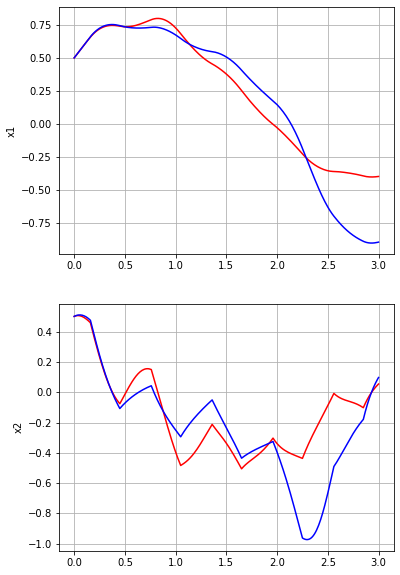

In [23]:
N_sim = 300
u_list = [(-1)**(round(i/30)) for i in range(N_sim)]

x0_np = np.array([[0.5],[0.5]])
x_true_np = x0_np

x_lift_np = lift_func(x0_np, Xc)

x_traj_true_list = []
x_traj_lift_list = []

x_traj_true_list += [x_true_np]
x_traj_lift_list += [x_lift_np]
for i in range(N_sim):
    x_true_np = np.array(sys_int_fn(x_true_np,u_list[i]))
    x_traj_true_list += [x_true_np]
    
    x_lift_np = A_lift_np @ x_lift_np + B_lift_np @ np.array(u_list[i]).reshape(-1,1)
    x_traj_lift_list += [x_lift_np]
    
x_traj_true_array = np.hstack(x_traj_true_list)
x_traj_lift_array = np.hstack(x_traj_lift_list)

x_koop_array = C_lift_np @ x_traj_lift_array

tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_koop = x_koop_array[i,:]
    x_true = x_traj_true_array[i,:]
    plt.plot(tgrid, x_koop, 'r')
    plt.plot(tgrid, x_true, 'b')
    plt.ylabel('x' + str(i + 1))

In [53]:
lift_sys_ode = define_lift_sys(A_lift_np,B_lift_np)
z_SX = ca.SX.sym("z_SX", N_lift)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [z_SX, u_SX], [lift_sys_ode(z_SX, u_SX)])

(50, 50) (2, 2)
current state and input [[0. ]
 [0.1]] [[-1.15645244]]
(50, 50) (2, 2)
current state and input [[0.00206071]
 [0.08939513]] [[-1.03856874]]
(50, 50) (2, 2)
current state and input [[0.00314097]
 [0.08091489]] [[-0.94357636]]
(50, 50) (2, 2)
current state and input [[0.00513515]
 [0.07390288]] [[-0.87059069]]
(50, 50) (2, 2)
current state and input [[0.0056604 ]
 [0.06687191]] [[-0.79110015]]
(50, 50) (2, 2)
current state and input [[0.00721931]
 [0.06097932]] [[-0.73181162]]
(50, 50) (2, 2)
current state and input [[0.0082407 ]
 [0.05412062]] [[-0.65413392]]
(50, 50) (2, 2)
current state and input [[0.00844083]
 [0.04882692]] [[-0.5968758]]
(50, 50) (2, 2)
current state and input [[0.0086437 ]
 [0.04312653]] [[-0.53193665]]
(50, 50) (2, 2)
current state and input [[0.01014226]
 [0.03824693]] [[-0.48099396]]
(50, 50) (2, 2)
current state and input [[0.01184142]
 [0.03339394]] [[-0.42898026]]
(50, 50) (2, 2)
current state and input [[0.01243473]
 [0.02926236]] [[-0.384059

current state and input [[ 0.00571819]
 [-0.0055635 ]] [[0.03379058]]
(50, 50) (2, 2)
current state and input [[ 0.00657907]
 [-0.00455034]] [[0.01565626]]
(50, 50) (2, 2)
current state and input [[ 0.0058276]
 [-0.0054416]] [[0.02823625]]
(50, 50) (2, 2)
current state and input [[ 0.00508492]
 [-0.00598643]] [[0.03575481]]
(50, 50) (2, 2)
current state and input [[ 0.00494136]
 [-0.00663692]] [[0.04471328]]
(50, 50) (2, 2)
current state and input [[ 0.00565137]
 [-0.00676492]] [[0.04318316]]
(50, 50) (2, 2)
current state and input [[ 0.00602297]
 [-0.00743771]] [[0.05176174]]
(50, 50) (2, 2)
current state and input [[ 0.00612501]
 [-0.00738136]] [[0.04899082]]
(50, 50) (2, 2)
current state and input [[ 0.00502158]
 [-0.00807913]] [[0.06048058]]
(50, 50) (2, 2)
current state and input [[ 0.00415757]
 [-0.00831344]] [[0.06485615]]
(50, 50) (2, 2)
current state and input [[ 0.00381209]
 [-0.00862431]] [[0.07057817]]
(50, 50) (2, 2)
current state and input [[ 0.0027128 ]
 [-0.00836119]] [

current state and input [[ 0.00014818]
 [-0.00357742]] [[0.0218231]]
(50, 50) (2, 2)
current state and input [[-0.00019312]
 [-0.00341489]] [[0.02277104]]
(50, 50) (2, 2)
current state and input [[-0.00084006]
 [-0.00245953]] [[0.01339651]]
(50, 50) (2, 2)
current state and input [[-0.00012349]
 [-0.00154482]] [[-0.0022876]]
(50, 50) (2, 2)
current state and input [[ 3.35478076e-06]
 [-2.13419671e-03]] [[0.00660624]]
(50, 50) (2, 2)
current state and input [[-0.00014341]
 [-0.00171106]] [[0.0036058]]
(50, 50) (2, 2)
current state and input [[-0.00020494]
 [-0.00072633]] [[-0.01009595]]
(50, 50) (2, 2)
current state and input [[-0.00017483]
 [-0.00084397]] [[-0.00958352]]
(50, 50) (2, 2)
current state and input [[-6.37786765e-05]
 [-1.25413230e-03]] [[-0.00177682]]
(50, 50) (2, 2)
current state and input [[ 0.00089657]
 [-0.00029977]] [[-0.01852278]]
(50, 50) (2, 2)
current state and input [[ 9.66621425e-05]
 [-8.77421531e-04]] [[-0.00885367]]
(50, 50) (2, 2)
current state and input [[-

current state and input [[ 0.00430657]
 [-0.00242847]] [[0.00146238]]
(50, 50) (2, 2)
current state and input [[ 0.00497773]
 [-0.00152356]] [[-0.01074604]]
(50, 50) (2, 2)
current state and input [[ 0.0053667 ]
 [-0.00083196]] [[-0.02049814]]
(50, 50) (2, 2)
current state and input [[ 0.00630846]
 [-0.00057891]] [[-0.02882863]]
(50, 50) (2, 2)
current state and input [[ 0.00637752]
 [-0.00165847]] [[-0.01722145]]
(50, 50) (2, 2)
current state and input [[ 0.00703192]
 [-0.00288148]] [[0.0002521]]
(50, 50) (2, 2)
current state and input [[ 0.00732769]
 [-0.00204852]] [[-0.01152707]]
(50, 50) (2, 2)
current state and input [[ 0.00797641]
 [-0.00191027]] [[-0.01499461]]
(50, 50) (2, 2)
current state and input [[ 0.00698733]
 [-0.00195271]] [[-0.01030716]]
(50, 50) (2, 2)
current state and input [[ 0.0059827 ]
 [-0.00120894]] [[-0.01636823]]
(50, 50) (2, 2)
current state and input [[ 0.00523246]
 [-0.00045082]] [[-0.02418016]]
(50, 50) (2, 2)
current state and input [[ 5.75714089e-03]
 [-

current state and input [[ 0.00109198]
 [-0.00382068]] [[0.02013912]]
(50, 50) (2, 2)
current state and input [[ 0.00166157]
 [-0.00456519]] [[0.02822561]]
(50, 50) (2, 2)
current state and input [[ 0.00201438]
 [-0.00491351]] [[0.03263166]]
(50, 50) (2, 2)
current state and input [[ 0.0028333 ]
 [-0.00475496]] [[0.02913222]]
(50, 50) (2, 2)
current state and input [[ 0.0036205 ]
 [-0.00454944]] [[0.02626128]]
(50, 50) (2, 2)
current state and input [[ 0.00453075]
 [-0.00386858]] [[0.0148941]]
(50, 50) (2, 2)
current state and input [[ 0.00540934]
 [-0.00384774]] [[0.01006581]]
(50, 50) (2, 2)
current state and input [[ 0.0060017 ]
 [-0.00486533]] [[0.02036661]]
(50, 50) (2, 2)
current state and input [[ 0.00631828]
 [-0.00580593]] [[0.03152147]]
(50, 50) (2, 2)
current state and input [[ 0.00718428]
 [-0.00623614]] [[0.03443892]]
(50, 50) (2, 2)
current state and input [[ 0.00742337]
 [-0.00665842]] [[0.04237201]]
(50, 50) (2, 2)
current state and input [[ 0.00791628]
 [-0.00561077]] 

current state and input [[ 0.00227564]
 [-0.00382679]] [[0.02094171]]
(50, 50) (2, 2)
current state and input [[ 0.00121496]
 [-0.00323208]] [[0.0149188]]
(50, 50) (2, 2)
current state and input [[ 0.00164646]
 [-0.0033192 ]] [[0.01553848]]
(50, 50) (2, 2)
current state and input [[ 0.00092404]
 [-0.00316473]] [[0.01685795]]
(50, 50) (2, 2)
current state and input [[ 0.00095155]
 [-0.00244513]] [[0.00661141]]
(50, 50) (2, 2)
current state and input [[-8.43423113e-05]
 [-2.55613702e-03]] [[0.01140059]]
(50, 50) (2, 2)
current state and input [[-0.00057917]
 [-0.00218758]] [[0.00967985]]
(50, 50) (2, 2)
current state and input [[ 0.00014817]
 [-0.00130387]] [[-0.00611248]]
(50, 50) (2, 2)
current state and input [[-0.00034579]
 [-0.00209389]] [[0.00348679]]
(50, 50) (2, 2)
current state and input [[-0.00137983]
 [-0.00303446]] [[0.02170673]]
(50, 50) (2, 2)
current state and input [[-0.00243629]
 [-0.00186514]] [[0.01058656]]
(50, 50) (2, 2)
current state and input [[-0.00181785]
 [-0.00

<ipython-input-159-bff5e6ad47b9>:985: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(Nx + Nu) + str(1) + str(i + 1))
<ipython-input-159-bff5e6ad47b9>:996: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(Nx + Nu) + str(1) + str(i + 1 + Nx))


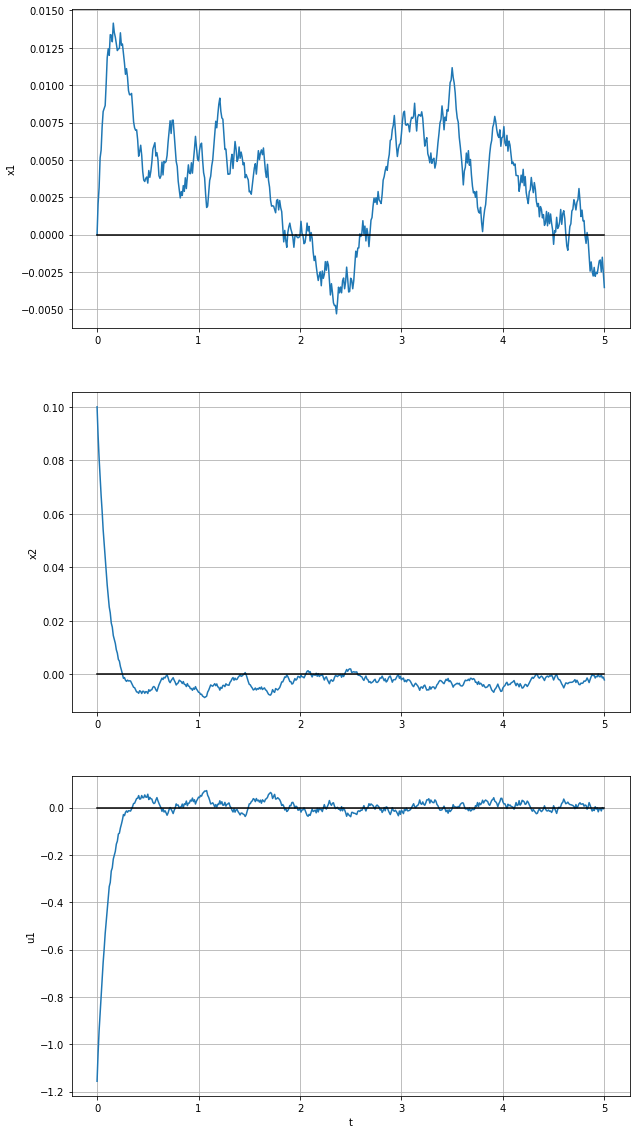

In [164]:

#     C = np.array([[0, 0], [1e-1, 0]])
#     # C = np.array([[0,0], [0, 0]])
#     D = np.array([[1, 0]])
#     E = np.array([[0, 1e-1]])
#     # E = np.array([[0, 0]])

C = np.zeros([N_lift,2])
# C[-1,-2] = 1e-3
C[-1,-1] = 1e-3
C[-2,-2] = 1e-3
D = np.hstack([np.zeros([Nx,N_lift-Nx]), np.eye(Nx)])
# D = np.array([[0]*N_rbf]+[])
E = np.zeros([Nx,2])
E[-1,-1] = 1e-3
# E[-1,-1] = 0
# E = np.array([0] * (N_lift-1) + [1e-1]).reshape(1,-1)

N = 25

x1_start = 0
x2_start = 0.1

x0 = np.array([[x1_start],[x2_start]])
z_init = lift_func(x0, Xc)

u_0 = np.array([[0]])

zr = np.zeros([N_lift,1])
ur = np.array([[0]])

x1_ub = 0.04
F = np.array([0] * (N_lift-2) + [1/x1_ub, 0]).reshape(1,-1)
G = np.array([[0]])
F_t = np.array([0] * (N_lift-2) + [1/x1_ub, 0]).reshape(1,-1)

Q = np.diag([0]* (N_lift-2) + [100] * 2)
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [50] * 2)

mu = np.zeros([2, 1])
sigma = 1
sin_const =1
# sin_const = 0

mass_sim = Simulation(ode, delta_t, N, z_init, C, D, E, F, G, F_t, Q, Qf, R, cont_time=False, nonlinear=False,
                      u_0=u_0,
                      xr=zr, ur=ur, collect=False, est=False, mu=mu, sigma=sigma, beta=1,
                      sin_const=sin_const, N_sample=1, epsilon=1, N_sim=500, data_set=None, N_sample_max=None, x_0 = x0)

mass_sim.plot_state()